# Battery Optimization

### 0.1 Imports of needed libraries  

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
from battery_optimization.data_handler import DataHandler
from battery_optimization.battery_optimizer import Battery, BatteryOptimizer, PyoBatteryOptimizer

In [3]:
dh = DataHandler()
df_prices = dh.hourly_df
prices = df_prices['price'].to_numpy()

19-Mar-23 19:04:40 - Loading existing processed file: dayahead_hourly.feather
19-Mar-23 19:04:40 - Loading existing processed file: dayahead_fifteen.feather


## 1. Problem definition

### 1.1 Scipy implementation

Using the formulation of `scipy.optimize.linprog`, with linear programming we want to minimize a linear objective function subject to linear equality and inequality constraints.

\begin{equation}
min_x(c^T x)
\end{equation}
subject to the conditions

\begin{align}
A_{ub}x\leq b_{ub}\\
A_{eq}x=b_{eq}\\
l\leq x \leq u,
\end{align}

In our case, we have a battery that can use the energy from the electricity grid to recharge ($P > 0.$) or can discharge ($P < 0.$) providing electricity back to the grid. The total cost or revenue of the single time interval $\Delta t$ is given by $c_i \cdot P_i \cdot \Delta t$, where $c_i$ is the price in €/MWh and $P_i$ is the average power of charge/discharge of the battery. The objective function that we want to minimize, in order to maximise the revenues, is:   

\begin{equation}
cost=\sum_{i=0}^{N} c_i P_i\Delta t
\end{equation}

The different constraints can be formalised as follows:
1. The power of charge/discharge is limited at all times $P_{min} \leq P_i \leq P_{max} \tag{1}$ with $P_{min} = -P_{max}$ in our formalism. 
2. The energy stored in the battery is limited at all times $0 \leq E_i \leq E_{max}$:
\begin{align}
E_i=\sum_{j=0}^i P_j \Delta t + E_0\\
\sum_{j=0}^i P_j \Delta t \leq E_{max} - E_0
\tag{2}
\end{align}

\begin{align}
- \sum_{j=0}^i P_j \Delta t \leq E_0
\tag{3}
\end{align}

The two inequalities can be expressed in matrix form with $T_{low}$ representing a low triangular matrix>

\begin{equation}
\left(
\begin{array}{c}
T_{low} \\
-T_{low}
\end{array}
\right)
\cdot P
\leq 
\left(\begin{array}{c}
E_{max} - E_0\\
E_0
\end{array}
\right)
\end{equation}

3. The final energy stored on the battery
\begin{equation}
E_{final} = \sum_{i=0}^N P_i \Delta t + E_0
\tag{4}
\end{equation}

### 1.2 Pyomo implementation

As a crosscheck, the problem has been implemented also using the pyomo (https://pyomo.readthedocs.io/en/stable/pyomo_overview/index.html) library. The definition of the problem remains the same, but there are some adjustments needed for the different infrastructure. The main difference will be the separation of the $P$ variable into a recharge $R$ and discharge $D$ variable, with $P = R - D$. 

#### 1. Parameters

In [4]:
dt = 1. #hours
E_0 = 0. #MWh
E_final = 0. #MWh
E_max = 2. #MWh
P_max = 1. #MW

#### 2. Battery Definition

In [5]:
bat = Battery(
    E_0=E_0,
    E_final=E_final,
    E_max=E_max,
    P_max=P_max,
    P_min=-P_max
)

#### 3. Optimization

Scipy implementation

In [6]:
opt = BatteryOptimizer(
    battery=bat,
    dt=dt,
    prices=prices,
).optimize()

In [7]:
print(f"Total Revenue {-1*np.sum(opt.x*prices):0.2f} €")

Total Revenue 69707.69 €


Pyomo implementation

In [8]:
pyomo_opt = PyoBatteryOptimizer(
    battery=bat,
    dt=dt,
    prices=prices,
    penalty=75.0
).optimize()

In [9]:
print(f"Total Revenue {-1*np.sum(pyomo_opt.power*prices):0.2f} €")

Total Revenue 53259.53 €


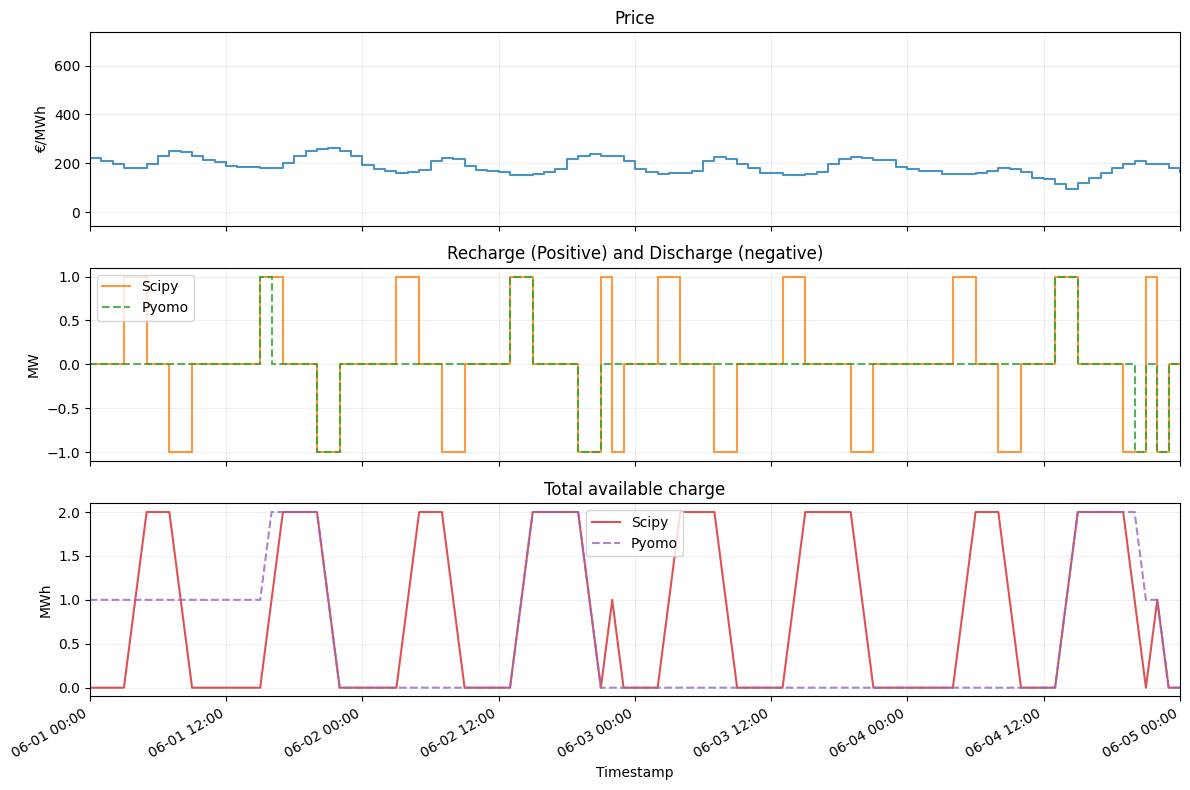

In [10]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(12,8))

sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y='price', 
    ax=ax[0], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Price"
)
ax[0].set_ylabel("€/MWh")
ax[0].set_title("Price")
ax[0].grid(alpha=0.2)

sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=opt.x, 
    ax=ax[1], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Scipy",
    color="C1"
)
sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=pyomo_opt.power, 
    ax=ax[1], 
    alpha=0.8, 
    drawstyle='steps-post', 
    label="Pyomo",
    color="C2",
    ls="dashed"
)
ax[1].set_ylabel("MW")
ax[1].set_title("Recharge (Positive) and Discharge (negative)")
ax[1].grid(alpha=0.2)

sns.lineplot(
    data=df_prices, 
    x='end_mtu', 
    y=np.cumsum(opt.x), 
    ax=ax[2], 
    alpha=0.8, 
    #drawstyle='steps-post', 
    label="Scipy",
    color="C3"
)
sns.lineplot(
    data=df_prices, 
    x='start_mtu', 
    y=pyomo_opt.capacity, 
    ax=ax[2], 
    alpha=0.8, 
    #drawstyle='steps-post', 
    label="Pyomo",
    color="C4",
    ls="dashed"
)
ax[2].set_ylabel("MWh")
ax[2].set_title("Total available charge")
ax[2].grid(alpha=0.2)

ax[0].set_xlim(pd.to_datetime(["2022-06-01 00:00", "2022-06-05 00:00"]))

ax[0].get_legend().remove()
#ax[1].get_legend().remove()
#ax[2].get_legend().remove()

date_formatter = mdates.DateFormatter('%m-%d %H:%M')
ax[2].xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()
ax[2].set_xlabel("Timestamp")

plt.tight_layout()